# Classification

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
import sys
sys.path.append('..')
import db
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
%matplotlib inline
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
working_experience='3_5'

In [3]:
conn=db.get_conn()
data_original=pd.read_sql(sql="select * from _201904 where monthly_salary>0 and monthly_salary<8  and city='shanghai' and experience_{}=1 and (edu_associate=1 or edu_bachelor=1 or edu_master=1 or edu_phd=1) order by monthly_salary".format(working_experience), con=conn)
conn.close()

In [4]:
data_original.shape

(7819, 161)

In [5]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [6]:
data.head()

,ageism,career,career_algorithm,career_architect,career_software_engineer,city,city_beijing,city_changchun,city_changsha,city_chengdu,...,ml_pytorch,ml_mxnet,ml_chainer,ml_keras,ml_deeplearning4j,ml_theano,ml_sklearn,ml_mahout,ml_paddlepaddle,career_spider
0,False,software,False,False,True,shanghai,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,software,False,False,True,shanghai,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,software,False,False,True,shanghai,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,software,False,False,True,shanghai,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,software,False,False,True,shanghai,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


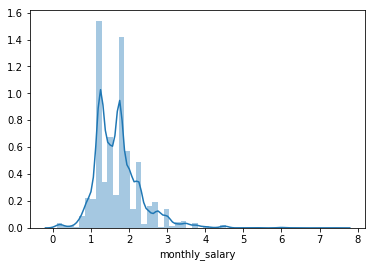

In [7]:
sns.distplot(data['monthly_salary'])

# Make Two Classes

In [124]:
q=np.quantile(data.monthly_salary.values,[0.35,0.5,0.71])

In [125]:
q

array([1.4  , 1.7  , 1.875])

In [126]:
data_low = data[data.monthly_salary<q[0]]
data_low.loc[:,'low']=1
data_high = data[data.monthly_salary>q[2]]
data_high.loc[:,'low']=0

In [127]:
print(data_low.shape, data_high.shape)
data_high.shape

(2647, 162) (2244, 162)


(2244, 162)

In [128]:
data_classification = data_low.append(data_high)

In [129]:
data_classification.shape

(4891, 162)

In [130]:
del data_classification['city']
del data_classification['monthly_salary']
del data_classification['career']
del data_classification['publish_date']
del data_classification['published_on_weekend']
del data_classification['title']
del data_classification['company_title']
del data_classification['company_description']
del data_classification['job_description']
del data_classification['job_id']

In [131]:
pd.options.display.max_columns=200
data_classification.head(10)

,ageism,career_algorithm,career_architect,career_software_engineer,city_beijing,city_changchun,city_changsha,city_chengdu,city_chongqing,city_dalian,city_dongguan,city_fuzhou,city_guangzhou,city_hangzhou,city_harbin,city_hefei,city_jinan,city_kuming,city_nanjing,city_ningbo,city_qingdao,city_shanghai,city_shenyang,city_shenzhen,city_tianjin,city_wuhan,city_xian,city_zhengzhou,company_size_10000,company_size_1000_5000,company_size_150_500,company_size_50,company_size_5000_10000,company_size_500_1000,company_size_50_150,company_tpye_jv,company_type_foreign,company_type_foreign_gov,company_type_foreign_rep,company_type_listed,company_type_non_profit,company_type_private,company_type_public_institution,company_type_startup,company_type_state,company_type_us_eu,db_Apache_Hive,db_CouchBase,db_CouchDB,db_DB2,db_DynamoDB,db_Elasticsearch,db_FileMaker,db_Firebase,db_Firebird,db_Hbase,db_Informix,db_Ingres,db_MariaDB,db_Memcached,db_MongoDB,db_MySQL,db_Neo4j,db_Netezza,db_Oracle,db_PostgreSQL,db_Redis,db_Riak,db_SAP_HANA,db_SQL_Server,db_SQLite,db_Solr,db_Splunk,db_Sybase,db_Teradata,db_dBase,edu_associate,edu_bachelor,edu_high_school,edu_master,edu_middle_school,edu_phd,english,experience_10,experience_1_3,experience_3_5,experience_5_10,experience_no,icu_996,industry_ads,industry_computer,industry_edu,industry_energy,industry_finance,industry_gov,industry_logistic,industry_medical,industry_realestate,industry_service,industry_trade,japanese,non_996,phone_android,phone_app,phone_iso,pl_assembly,pl_c_sharp,pl_cpp,pl_delphi,pl_go,pl_groovy,pl_haskell,pl_java,pl_javascript,pl_julia,pl_kotlin,pl_lua,pl_matlab,pl_objective_c,pl_perl,pl_php,pl_python,pl_ruby,pl_rust,pl_scala,pl_swift,pl_typescript,pl_vba,pl_visual_basic,pl_visual_basic_net,pl_r,tag_baby_care,tag_five_insurance,tag_flexible,tag_no_overtime,tag_rest_one_day,tag_rest_two_days,tag_stock,ml_tensorflow,ml_caffe,ml_cntk,ml_pytorch,ml_mxnet,ml_chainer,ml_keras,ml_deeplearning4j,ml_theano,ml_sklearn,ml_mahout,ml_paddlepaddle,career_spider,low
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,

## Feature Selection

In [132]:
def del_by_prefix(data, pref):
    for col in data.columns:
        if col.startswith(pref):
            del data[col]

In [133]:
del_by_prefix(data_classification, 'city_')

In [134]:
#del_by_prefix(data, 'company_type')

In [135]:
#del_by_prefix(data, 'db_')

In [136]:
pickle.dump(data_classification,open('shanghai_experience_{}.dmp'.format(working_experience),mode='wb'))

In [89]:
y=data_classification.low
#y=data.monthly_salary
X=data_classification.drop('low', axis=1)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [91]:
X_train.shape

(3303, 127)

In [92]:
lr=LogisticRegression()

In [93]:
lr_model=lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [94]:
lr_model.score(X_train, y_train)

0.7096578867696034

In [95]:
lr_model.score(X_test, y_test)

0.7082309582309583

In [96]:
len(lr_model.coef_)

1

In [97]:
X.shape

(4931, 127)

## Decision Tree

In [98]:
from sklearn.tree import DecisionTreeClassifier

In [99]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3)

In [100]:
dt_model=dt.fit(X_train, y_train)

In [101]:
dt_model.score(X_train, y_train)

0.6297305479866788

In [102]:
dt_model.score(X_test, y_test)

0.6203931203931204

In [103]:
from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(dt_model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

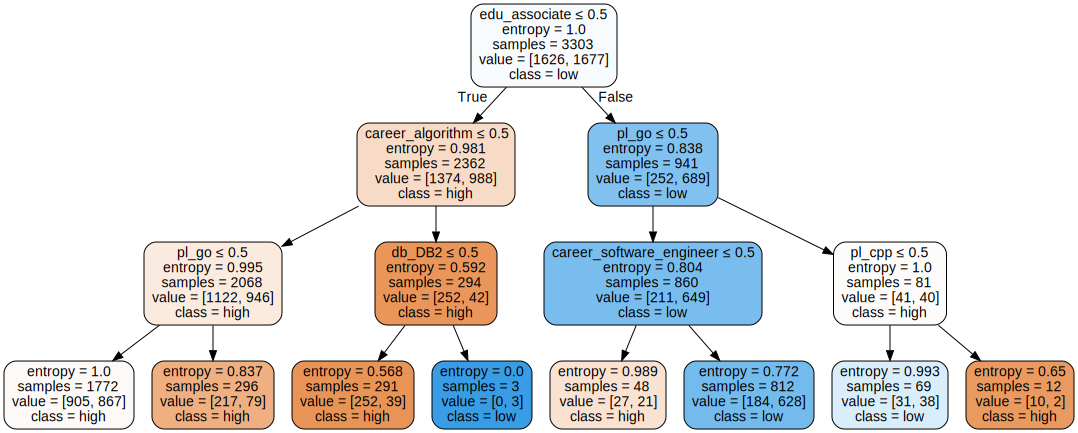

In [104]:
dot_data = tree.export_graphviz(dt_model, out_file=None, 
                      feature_names=X.columns,  
                      class_names=['high','low'],  
                      filled=True, rounded=True,  
                      special_characters=True)  

graph = graphviz.Source(dot_data)  
graph

In [105]:
new_dot_data=dot_data.replace('True','no').replace('False','yes').replace(' &le; 0.5','?')
print(new_dot_data)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label=<edu_associate?<br/>entropy = 1.0<br/>samples = 3303<br/>value = [1626, 1677]<br/>class = low>, fillcolor="#399de508"] ;
1 [label=<career_algorithm?<br/>entropy = 0.981<br/>samples = 2362<br/>value = [1374, 988]<br/>class = high>, fillcolor="#e5813948"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="no"] ;
2 [label=<pl_go?<br/>entropy = 0.995<br/>samples = 2068<br/>value = [1122, 946]<br/>class = high>, fillcolor="#e5813928"] ;
1 -> 2 ;
3 [label=<entropy = 1.0<br/>samples = 1772<br/>value = [905, 867]<br/>class = high>, fillcolor="#e581390b"] ;
2 -> 3 ;
4 [label=<entropy = 0.837<br/>samples = 296<br/>value = [217, 79]<br/>class = high>, fillcolor="#e58139a2"] ;
2 -> 4 ;
5 [label=<db_DB2?<br/>entropy = 0.592<br/>samples = 294<br/>value = [252, 42]<br/>class = high>, fillcolor="#e58139d4"] ;
1 -> 5 ;
6 [label=<entropy = 0.568<br/>samples = 291<br/>val

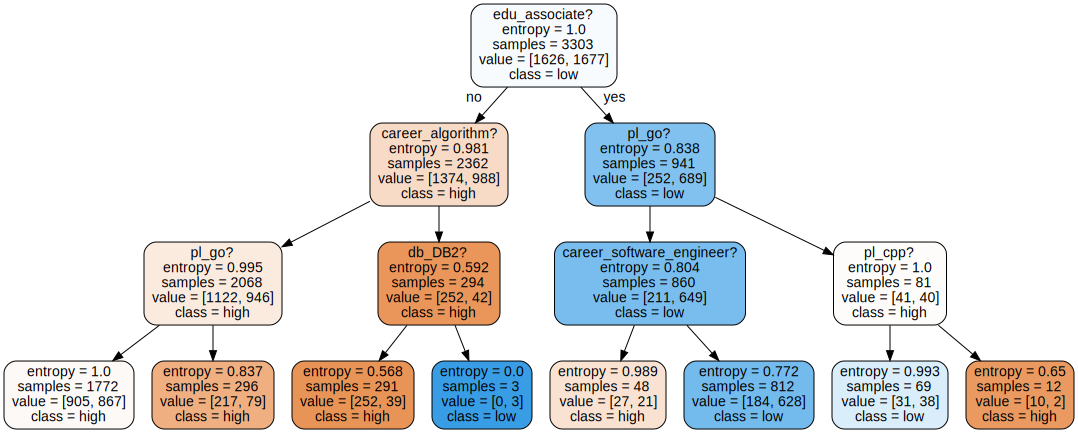

In [106]:
graph = graphviz.Source(new_dot_data)  
graph.render('shanghai_working_'+working_experience, format='png')
graph